## Topography filtering 

We don't really want to filter topography, as a coarse model is sort of a sub-sampled topography rather than filtered. 

Here we see if this impacts the thickness fluxes. 

#### Setup dask

When doing filtering, it may be useful to use many processes as it is very slow but easily parallelizable. 

In [26]:
I_want_dask = False

if I_want_dask: 
    from dask_gateway import Gateway
    gateway = Gateway()
    
    # close existing clusters
    open_clusters = gateway.list_clusters()
    print(list(open_clusters))
    
    flag_shut = False 
    
    if flag_shut: 
        if len(open_clusters)>0:
            for c in open_clusters:
                cluster = gateway.connect(c.name)
                cluster.shutdown()  
    
    options = gateway.cluster_options()
    
    #options.worker_memory = 16 # 24 works fine for long term mean, but seasonal needs a bit more
    # options.worker_cores = 8
    
    options.environment = dict(
        DASK_DISTRIBUTED__SCHEDULER__WORKER_SATURATION="1.0"
    )
    
    # Create a cluster with those options
    cluster = gateway.new_cluster(options)
    client = cluster.get_client()
    cluster.adapt(15, 40)
    #cluster.scale(10)
    client

[]


Connection method: Cluster object,Cluster type: dask_gateway.GatewayCluster
Dashboard: /services/dask-gateway/clusters/prod.407e313c3b834078b58ea7cbe6fd8791/status,


### Start

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from xgcm import Grid
#from xmitgcm import open_mdsdataset
import xrft
#from scipy.ndimage import gaussian_filter
import gcm_filters as gcmf

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
PERSISTENT_BUCKET = os.environ['PERSISTENT_BUCKET']

In [3]:
ds = xr.open_zarr(f'{PERSISTENT_BUCKET}/MOM6/Double_Gyre/res5km/prog.zarr')

### Model state

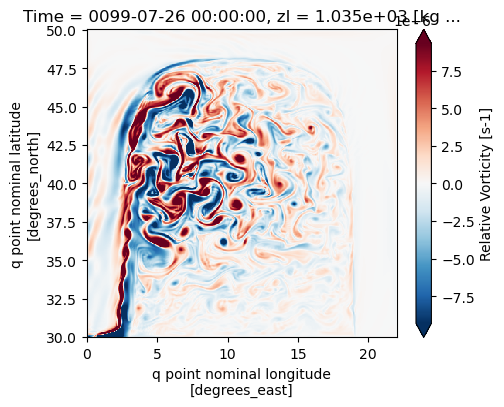

In [4]:
plt.figure(figsize=(5,4))
ds.RV.isel(Time=-1, zl=0).plot(robust=True)

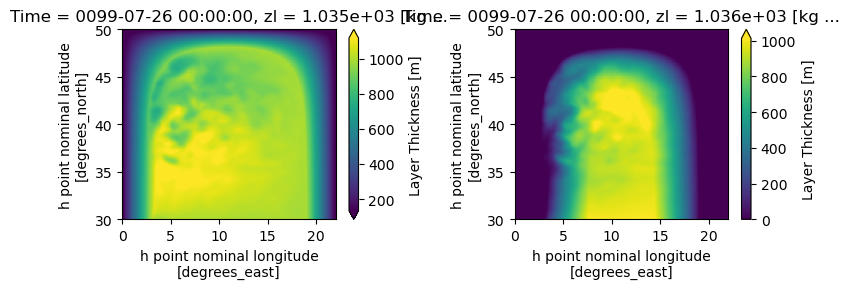

In [5]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds.h.isel(Time=-1, zl=0).plot(robust=True)

plt.subplot(122)
ds.h.isel(Time=-1, zl=1).plot(robust=True)

plt.tight_layout()

Text(0.5, 1.0, 'Thicknesses')

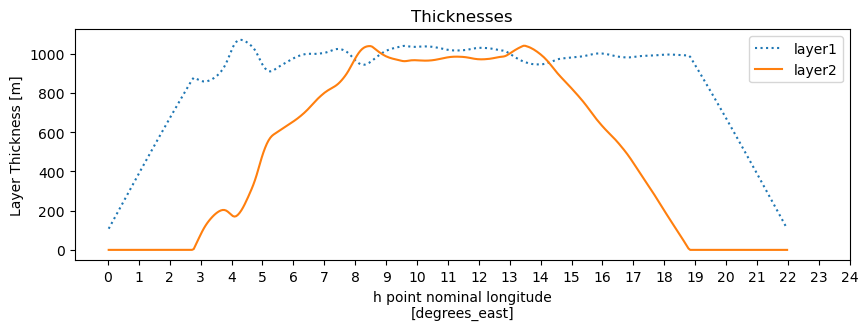

In [6]:
plt.figure(figsize=(10,3))
ds.h.isel(Time=-1, zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel(Time=-1, zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')

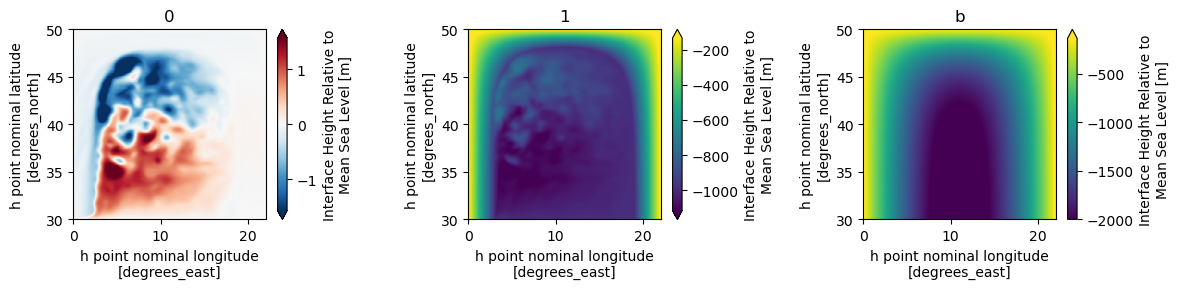

In [7]:
plt.figure(figsize=(12,3))

plt.subplot(131)
ds.e.isel(Time=-1, zi=0).plot(robust=True)
plt.title('0')

plt.subplot(132)
ds.e.isel(Time=-1, zi=1).plot(robust=True)
plt.title('1')

plt.subplot(133)
ds.e.isel(Time=-1, zi=2).plot(robust=True)
plt.title('b')

plt.tight_layout()

Text(0.5, 1.0, 'interfaces')

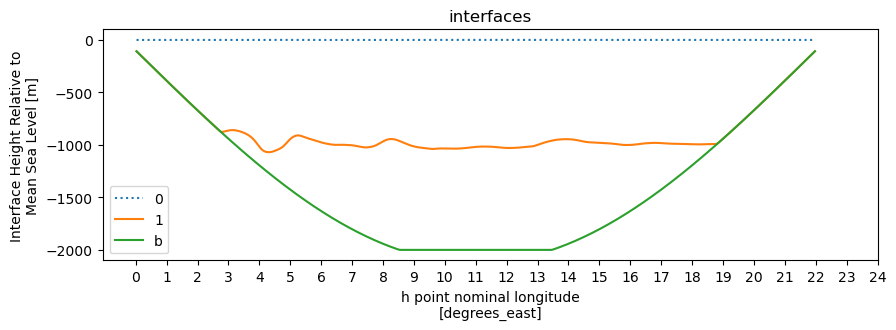

In [8]:
plt.figure(figsize=(10,3))
ds.e.isel(Time=-1, zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(yh=40, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

Text(0.5, 1.0, 'interfaces')

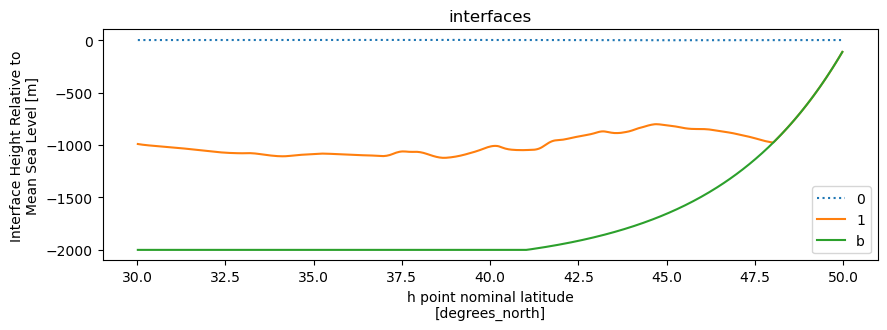

In [9]:
plt.figure(figsize=(10,3))
ds.e.isel(Time=-1, zi=0).sel(xh=9, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(xh=9, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(xh=9, method='nearest').plot(label='b')
plt.legend()
#plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

### Filtering

In [10]:
#ds = ds.isel(Time=slice(-3,-1))

In [11]:
Lfilter = 100e3
dx = 1/20 * 100e3

In [12]:
#wet_mask= (ds.h.isel(Time=0, zl=0)*0. + 1.).rename('wet_mask')
wet_mask= (ds.h.isel(Time=0, zl=1)>1).astype('float32').rename('wet_mask')
# Changning this wet mask changes things a little bit. 

In [13]:
filter_C = gcmf.Filter(filter_scale= Lfilter,  
                     dx_min = dx, 
                     filter_shape=gcmf.FilterShape.GAUSSIAN,
                     grid_type=gcmf.GridType.REGULAR_WITH_LAND,
                     grid_vars = {'wet_mask': wet_mask})

In [14]:
xgrid = Grid(ds, coords={'X': {'center': 'xh', 'outer': 'xq'},
                         'Y': {'center': 'yh', 'outer': 'yq'},
                         'Z': {'center': 'zl', 'outer': 'zi'} },
             periodic=['X'])

In [15]:
ds_filt = xr.Dataset() 
ds_filt['h'] = filter_C.apply(ds.h, dims=['yh','xh']).rename('h')
ds_filt['e'] = filter_C.apply(ds.e, dims=['yh','xh']).rename('e')

In [16]:
#ds_filt.load();

In [17]:
ds_anom = ds - ds_filt

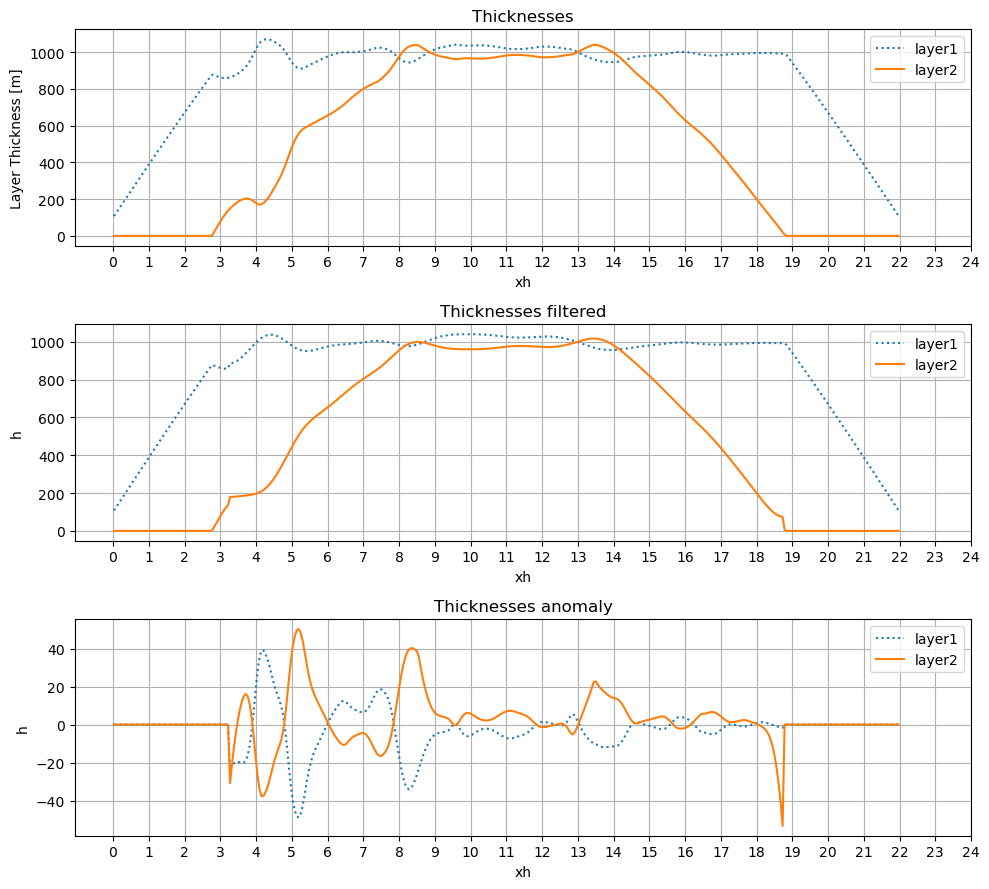

In [18]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.h.isel(Time=-1, zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds.h.isel(Time=-1, zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses')
plt.grid()

plt.subplot(312)
ds_filt.h.isel(Time=-1, zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds_filt.h.isel(Time=-1, zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses filtered')
plt.grid()

plt.subplot(313)
ds_anom.h.isel(Time=-1, zl=0).sel(yh=40, method='nearest').plot(linestyle=':',label='layer1')
ds_anom.h.isel(Time=-1, zl=1).sel(yh=40, method='nearest').plot(label='layer2')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('Thicknesses anomaly')
plt.grid()

plt.tight_layout()

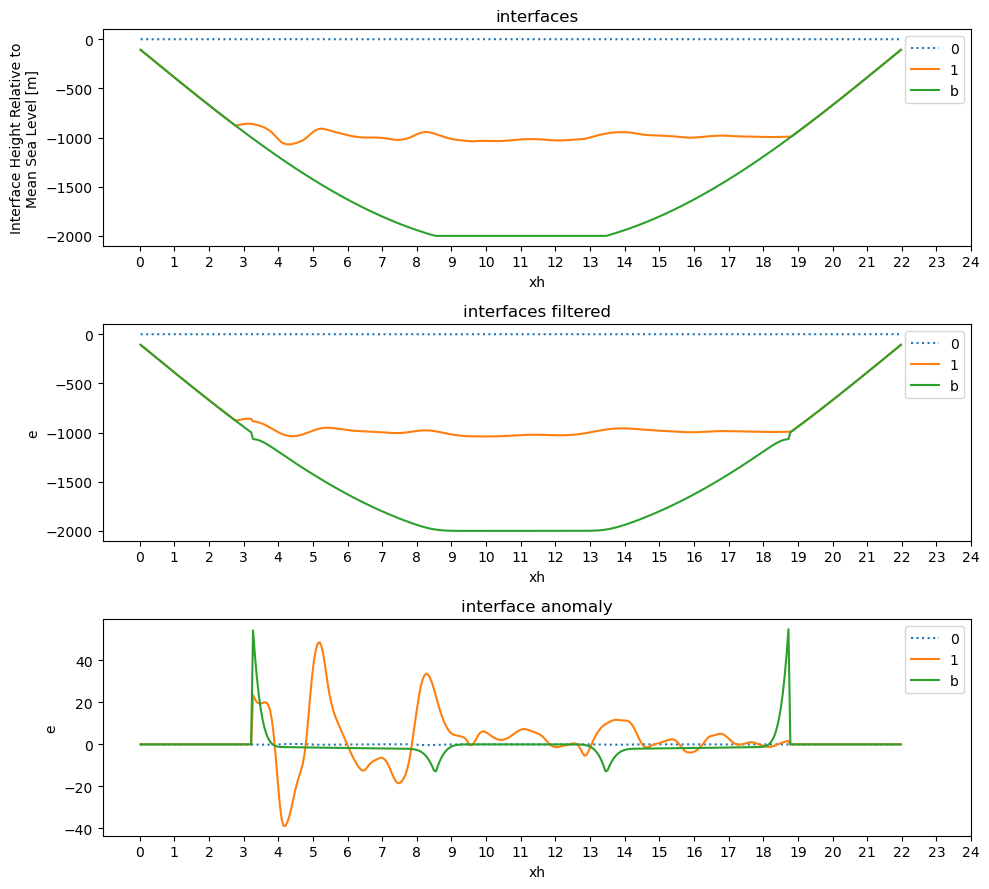

In [19]:
plt.figure(figsize=(10,9))

plt.subplot(311)
ds.e.isel(Time=-1, zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds.e.isel(Time=-1, zi=1).sel(yh=40, method='nearest').plot(label='1')
ds.e.isel(Time=-1, zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces')

plt.subplot(312)
ds_filt.e.isel(Time=-1, zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds_filt.e.isel(Time=-1, zi=1).sel(yh=40, method='nearest').plot(label='1')
ds_filt.e.isel(Time=-1, zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interfaces filtered')

plt.subplot(313)
ds_anom.e.isel(Time=-1, zi=0).sel(yh=40, method='nearest').plot(linestyle=':',label='0')
ds_anom.e.isel(Time=-1, zi=1).sel(yh=40, method='nearest').plot(label='1')
ds_anom.e.isel(Time=-1, zi=2).sel(yh=40, method='nearest').plot(label='b')
plt.legend()
plt.xticks(np.arange(0,25, 1));
plt.title('interface anomaly')

plt.tight_layout()

note that there are 2 things going on above to do with topography. 
1. There is the boundary issue, where the filter passes through the boundary, which creates a spike.
2. Also the filtered bottom interface is always a bit below the unfiltered (concave shape), which add a sign definite bias. [Except in region with flat bottom].

Does any of this impact the fluxes? 

In [20]:
u_c = xgrid.interp(ds.u.fillna(0), 'X')
v_c = xgrid.interp(ds.v.fillna(0), 'Y')
ds_filt['u'] = filter_C.apply(u_c, dims=['yh','xh']).rename('u')
ds_filt['v'] = filter_C.apply(v_c, dims=['yh','xh']).rename('v')

In [21]:
## Thickness method <uh> - <u><h>
ds_filt['vh'] = ds.h*v_c
ds_filt['vh_bar'] = filter_C.apply(ds_filt['vh'], dims=['yh','xh']).rename('vh_bar')
ds_filt['vbar_hbar'] = (ds_filt.h*ds_filt.v)
ds_filt['vh_sg'] = ds_filt['vh_bar'] - ds_filt['vbar_hbar']

ds_filt['uh'] = ds.h*u_c
ds_filt['uh_bar'] = filter_C.apply(ds_filt['uh'], dims=['yh','xh']).rename('uh_bar')
ds_filt['ubar_hbar'] = (ds_filt.h*ds_filt.u)
ds_filt['uh_sg'] = ds_filt['uh_bar'] - ds_filt['ubar_hbar']

In [22]:
## Interface method 
ds_filt['v2e1'] = ds.e.isel(zi=1)*v_c.isel(zl=1)
ds_filt['v2e1_bar'] = filter_C.apply(ds_filt['v2e1'], dims=['yh','xh']).rename('v2e1_bar')
ds_filt['v2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.v.isel(zl=1))
ds_filt['v2e1_sg'] = ds_filt['v2e1_bar'] - ds_filt['v2bar_e1bar']

ds_filt['u2e1'] = ds.e.isel(zi=1)*u_c.isel(zl=1)
ds_filt['u2e1_bar'] = filter_C.apply(ds_filt['u2e1'], dims=['yh','xh']).rename('u2e1_bar')
ds_filt['u2bar_e1bar'] = (ds_filt.e.isel(zi=1)*ds_filt.u.isel(zl=1))
ds_filt['u2e1_sg'] = ds_filt['u2e1_bar'] - ds_filt['u2bar_e1bar']

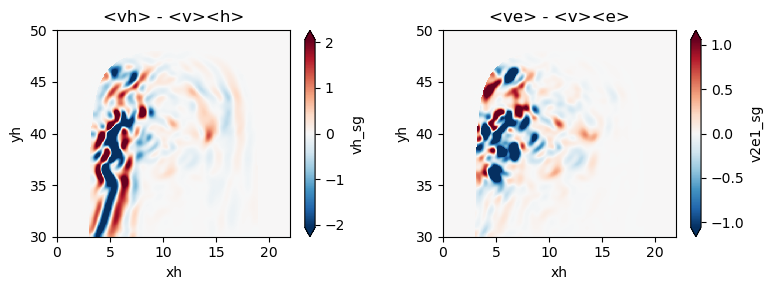

In [23]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=-1).plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel( Time=-1).plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

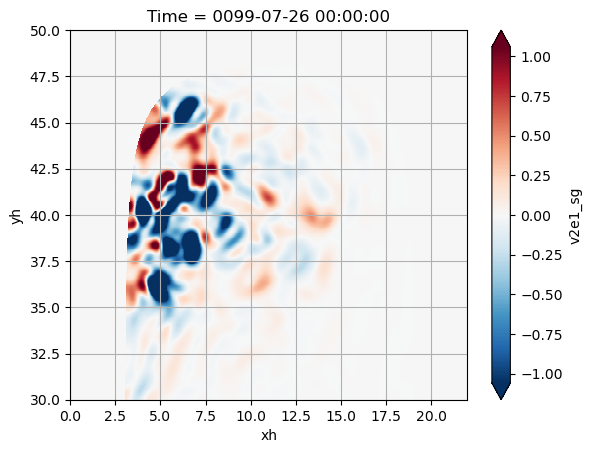

In [25]:
ds_filt['v2e1_sg'].isel( Time=-1).plot(robust=True)
plt.ylim(30,50)
plt.grid()

In [24]:
ds_filt['v2e1_sg'].Time.isel( Time=-1)

<xarray.DataArray 'Time' ()>
array(cftime.DatetimeJulian(99, 7, 26, 0, 0, 0, 0, has_year_zero=False),
      dtype=object)
Coordinates:
    Time     object 0099-07-26 00:00:00

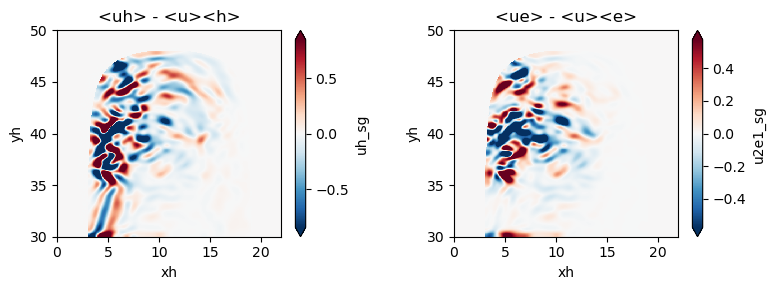

In [24]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['uh_sg'].isel(zl=-1, Time=-1).plot(robust=True)
plt.title('<uh> - <u><h>')

plt.subplot(122)
ds_filt['u2e1_sg'].isel( Time=-1).plot(robust=True)
plt.title('<ue> - <u><e>')

plt.tight_layout()

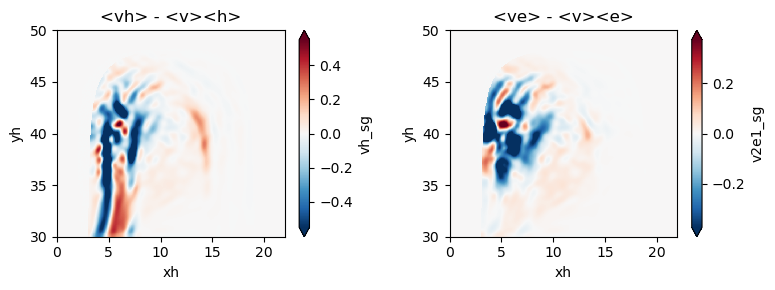

In [62]:
plt.figure(figsize=(8,3))

plt.subplot(121)
ds_filt['vh_sg'].isel(zl=-1, Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<vh> - <v><h>')

plt.subplot(122)
ds_filt['v2e1_sg'].isel(Time=slice(-100,-1)).mean('Time').plot(robust=True)
plt.title('<ve> - <v><e>')

plt.tight_layout()

## When done

In [64]:
cluster.shutdown()